### Imports

In [1]:
import os
import pandas as pd
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib import pyplot
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot
from numpy import mean
from numpy import std
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from pycm import *
from sklearn.metrics import roc_curve
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score


In [2]:
os.chdir(r'C:\Users\c2098580\OneDrive - Cardiff University\Desktop\MAC\MSc Data Science and Analytics/Dissertation/clean_data')
# read data
df = pd.read_csv('mh_counselling_df.csv')

In [3]:
# drop Unnamed column
df = df.drop('Unnamed: 0',axis=1)

In [4]:
# create df for the features and the target variable 
target = df['mh_counselling']

# selected features 
features = df.drop('mh_counselling',axis=1)

print('Shape of X data:',target.shape)
print('Shape of y data:',features.shape)

Shape of X data: (808,)
Shape of y data: (808, 94)


# Oversampling

Class=0, n=753 (93.193%)
Class=1, n=55 (6.807%)


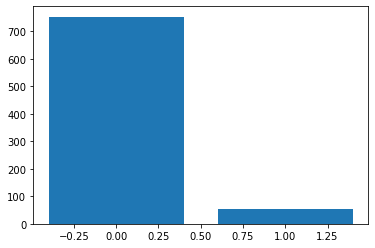

In [5]:
counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

Class=0, n=753 (50.000%)
Class=1, n=753 (50.000%)


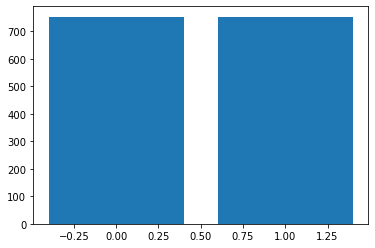

In [6]:
# transform the dataset
# show what smote does
oversample = SMOTE(k_neighbors=10)
feature_example, target_example = oversample.fit_resample(features, target)
# summarize distribution
counter = Counter(target_example)
for k,v in counter.items():
    per = v / len(target_example) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

# Model - KNN

### Define X and y

In [7]:
X = features

y = target

#### Model

In [8]:
def get_models():
    models = dict()
    for n_neighbors in range(1, 31): 
        for weights in ['uniform','distance']:
            # create name for model
            key = 'n_neighbors',n_neighbors,'weights',weights
            # models
            models[key] = KNeighborsClassifier(n_neighbors=n_neighbors,weights=weights)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    # define pca
    pca = PCA()
    # create pipeline to scale data and apply pca
    model = Pipeline(steps=[('over', SMOTE()),('under',RandomUnderSampler()),("scaling", StandardScaler()),
                                               ('pca', pca),("model", model)])
    # evaluate the model
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    return scores
 
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names, sd = list(), list(),list()
for name, model in models.items():
    # evaluate the model and collect the scores
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(mean(scores))
    sd.append(std(scores))
    names.append(name)

In [9]:
model_name = pd.DataFrame([str(x) for x in names], columns=['model_name'])
roc_auc = pd.DataFrame(results,columns=['roc_auc'])
sd = pd.DataFrame(sd,columns=['std'])
#store results
results = pd.concat([model_name, roc_auc,sd], axis=1, join="inner")
# find best roc_auc
print(results.sort_values('roc_auc',ascending=False).iloc[0,:])

model_name    ('n_neighbors', 28, 'weights', 'distance')
roc_auc                                         0.610945
std                                            0.0928566
Name: 55, dtype: object


# Model - Logistic regression

### Define X and y

In [10]:
X = features

y = target

#### Model

In [11]:
def get_models():
    models = dict()
    for c_space in np.logspace(-5, 8, 15): 
        for solver in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
            # create name for model
            key = 'c_space',c_space,'solver',solver
            # models
            models[key] = LogisticRegression(C=c_space,solver=solver,class_weight='balanced')
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    # define pca
    pca = PCA()
    # create pipeline to scale data and apply pca
    model = Pipeline(steps=[('over', SMOTE()),('under',RandomUnderSampler()),("scaling", StandardScaler()),
                                               ('pca', pca),("model", model)])
    # evaluate the model
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    return scores
 
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names, sd = list(), list(),list()
for name, model in models.items():
    # evaluate the model and collect the scores
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(mean(scores))
    sd.append(std(scores))
    names.append(name)

In [12]:
model_name = pd.DataFrame([str(x) for x in names], columns=['model_name'])
roc_auc = pd.DataFrame(results,columns=['roc_auc'])
sd = pd.DataFrame(sd,columns=['std'])
#store results
results = pd.concat([model_name, roc_auc,sd], axis=1, join="inner")
# find best roc_auc
print(results.sort_values('roc_auc',ascending=False).iloc[0,:])

model_name    ('c_space', 8.483428982440725e-05, 'solver', '...
roc_auc                                                0.677099
std                                                    0.112516
Name: 6, dtype: object


In [13]:
print(results.sort_values('roc_auc',ascending=False).iloc[0,0])

('c_space', 8.483428982440725e-05, 'solver', 'lbfgs')


In [14]:
# define the logistic regression model
model = LogisticRegression(C=1e-05,solver='sag')
# define pca
pca = PCA()
# create pipeline to scale data and apply pca
model = Pipeline(steps=[('over', SMOTE()),('under',RandomUnderSampler()),("scaling", StandardScaler()),
                        ('pca', pca),("model", model)])
# split the data into test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47,stratify=y)

#### Train AUC

In [15]:
# fit the model on the training dataset
model.fit(X_train, y_train)
# make a prediction
y_pred = model.predict(X_train)

roc_auc_score(y_train, y_pred)

0.6150754019774293

#### Test AUC

In [16]:
# fit the model on the training dataset
model.fit(X_train, y_train)
# make a prediction
y_pred = model.predict(X_test)

roc_auc_score(y_test, y_pred)

0.6799843831337845

In [17]:
cm = ConfusionMatrix(actual_vector=y_test, predict_vector=y_pred)

pycmVectorError: The type of input vectors is assumed to be a list or a NumPy array

In [ ]:
print(cm)

In [ ]:
y_pred_prob = model.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.show()

In [ ]:
model.named_steps['model'].coef_ 

# Model - SVM

### Define X and y

In [18]:
X = features

y = target

#### Model

In [19]:
def get_models():
    models = dict()
    for c_space in [0.1,1,10,100,1000]: 
        for gamma in [0.001, 0.01, 0.1, 1]:
            # create name for model
            key = 'c_space',c_space,'gamma',gamma
            # models
            models[key] = SVC(C=c_space,gamma=gamma)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    # define pca
    pca = PCA()
    # create pipeline to scale data and apply pca
    model = Pipeline(steps=[('over', SMOTE()),('under',RandomUnderSampler()),("scaling", StandardScaler()),
                                               ('pca', pca),("model", model)])
    # evaluate the model
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    return scores
 
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names, sd = list(), list(),list()
for name, model in models.items():
    # evaluate the model and collect the scores
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(mean(scores))
    sd.append(std(scores))
    names.append(name)

In [20]:
model_name = pd.DataFrame([str(x) for x in names], columns=['model_name'])
roc_auc = pd.DataFrame(results,columns=['roc_auc'])
sd = pd.DataFrame(sd,columns=['std'])
#store results
results = pd.concat([model_name, roc_auc,sd], axis=1, join="inner")
# find best roc_auc
print(results.sort_values('roc_auc',ascending=False).iloc[0,:])

model_name    ('c_space', 0.1, 'gamma', 0.001)
roc_auc                               0.654641
std                                   0.117591
Name: 0, dtype: object
